This Python script code was developed by dr. F. Brandolini and G. Domingo-Ribas to accompany the paper: *Brandolini F., Domingo-Ribas G., Zerboni A. & Turner S. "A Google Earth Engine-enabled Python approach to improve identification of anthropogenic palaeo-landscape features"*, submitted to *Open Research Europe*, 20XX

In [ ]:
# Mounting your Google Drive in the runtime's virtual machine

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Install Python Modules

# ! pip install geemap
# ! pip install rasterio

In [ ]:
## Import Python Modules

import ee
import geemap.eefolium as geemap
import os

In [ ]:
## Open a folium map object with 'geemap'

Map = geemap.Map()

Set your Area Of Interest (AOI) / Region Of Interest (ROI)
It could be done in two ways: 1) via Esri Shapefile (stored in your Drive), 2) creating a geometry object with coordinates. Here we present an example of method 2 with the coordinates of the Bronze Age Village "*Fabbrica dei Soci*" (see below).

In [ ]:
## Method 1) to use a Esri Shapefile, set the shpfile path!
 
  # aoi_shp = '/content/drive/My Drive/My Folder/My File.shp'
 
  ## Create your own AOI and ROI from Esri Shapefile!
 
  # AOI = geemap.shp_to_ee(aoi_shp)
  # ROI = AOI.geometry()

## Method 2) same ROI created setting a GEE geometry (this method do not require to upload any file in Drive!)

# # # Es.Bronze Age Village "Santa Rosa Poviglio"
# ROI = ee.Geometry.Polygon(
# [[[10.563442432823033,44.850325629121116],
# [10.604383671226353,44.850325629121116],
# [10.604383671226353,44.87958694587485],
# [10.563442432823033,44.87958694587485]]], 'EPSG:4326', False)

# ## Es. Valli Nuove di Guastalla - Buried Roman centuriation
# ROI = ee.Geometry.Polygon(
# [[[10.698238284450632,44.897288682786915],
# [10.725274951320749,44.897288682786915],
# [10.725274951320749,44.9140670791363],
# [10.698238284450632,44.9140670791363]]], 'EPSG:4326', False)

# # ## Es. Pra' Mantovani - Medieval structures and canals
# ROI = ee.Geometry.Polygon(
# [[[11.023105638420802,45.10809520671407],
# [11.043190019524317,45.10809520671407],
# [11.043190019524317,45.122419834412476],
# [11.023105638420802,45.122419834412476]]], 'EPSG:4326', False)

# # # Es.Bronze Age Village "Fabbrica dei Soci"
ROI = ee.Geometry.Polygon(
[[[11.349139311473449,45.09478572698541],
[11.348401747306402, 45.076797294992204],
[11.323013026554289, 45.077316817088835],
[11.323742634456798,45.095305573211924]]], 'EPSG:4326', False)

# # # # Es.Etruscan settlement, "Spina" + Early "Medieval Santa Maria in Pado Vetere"
# ROI = ee.Geometry.Polygon(
# [[[12.093508011733007,44.6536891976057],
# [12.152902848158789,44.6536891976057],
# [12.152902848158789,44.694827139754736],
# [12.093508011733007,44.694827139754736]]], 'EPSG:4326', False)

# # ## Es. Altinum - Buried Roman city
# ROI = ee.Geometry.Polygon(
# [[[12.379299789151386,45.53298056239308],
# [12.4089113766758,45.53298056239308],
# [12.4089113766758,45.554260528642864],
# [12.379299789151386,45.554260528642864]]], 'EPSG:4326', False)


Spectral indices & Spectral decomposition analysis (dr. F. Brandolini)

In [ ]:
# Importing Copernicus Sentinel 2_SR
# This is the cloud masking function provided by GEE but adapted for use in Python.

def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
  
  return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image,["system:time_start"])
 
# Filtering the autum/winter S2 collection and calculate the mean values
# January/March

Jan_Mar = (ee.ImageCollection('COPERNICUS/S2')
          .filterBounds(ROI)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .select(['B2','B3','B4','B8','B11','B12','QA60'])
          .filter(ee.Filter.dayOfYear(1,90)))
      
# October/December

Oct_Dec = (ee.ImageCollection('COPERNICUS/S2')
          .filterBounds(ROI)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .select(['B2', 'B3','B4','B8','B11','B12','QA60'])
          .filter(ee.Filter.dayOfYear(270,360)))

# Autumn/Winter merge

AutWin = Jan_Mar.merge(Oct_Dec)
 
S2_coll = (AutWin.map(maskS2clouds))

# reducing the collection in a single image: the choice of selecting 4-bands or 6-bands file depends on the spectral analysis (BSI, TCT, PCA...) that we want to perform.

# 4-bands image 

S2_4bands = (S2_coll.select(['B2','B3','B4','B8']).mean().clip(ROI))

# 6-bands image

S2_6bands = (S2_coll.select(['B2','B3','B4','B8','B11','B12']).mean().clip(ROI))

In [ ]:
# RGB composite

#  bands 4–3–2 (Red/Green/Blue), visualisation parameters:

vis_S2_RGB = {
    'bands': ['B4', 'B3', 'B2'],
    'min': [0.0882434, 0.101549, 0.125887],
    'max': [0.127416, 0.130167, 0.149021],
  }

#  bands 12-8-4 (SWIR/NIR/Red), visualisation parameters:

vis_S2_SwirNirRed = {
    'bands': ['B12', 'B8', 'B4'],
    'min': [0.0838677, 0.108894, 0.0862848],
    'max': [0.143167, 0.231982, 0.122846],
  }

In [ ]:
## Bare Soil Index (BSI), formula: ((Red+SWIR) - (NIR+Blue)) / ((Red+SWIR) + (NIR+Blue))

## BSI (Sentinel 2) = (B11 + B4) – (B8 + B2) / (B11 + B4) + (B8 + B2)

BSI = S2_6bands.expression('((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))' ,{
    'nir':S2_6bands.select('B8'),
    'swir':S2_6bands.select('B12'),
    'red':S2_6bands.select('B4'),
    'blue':S2_6bands.select('B2'),
}).rename('BSI')

# BSI visualisation parameters:

BSI_vis = {
    'min': -0.148425, 
    'max': 0.0368514, 
    'palette': ['#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd']} #Spectral


In [ ]:
# ## Hue, Saturation and Value (HSV)

# Convert the RGB bands to the HSV color space.

HSV = (S2_coll.select(['B2','B3','B4']).mean().clip(ROI)).rgbToHsv()

In [ ]:
## Tassellation Cap Transformation (6 Bands)

## TCT components were computed using both the six bands described in the formulas 

## Create an Array of Tasseled Cap coefficients.
## • TCT-band 1 (brightness, measure of soil)
## • TCT-band 2 (greenness, measure of vegetation)
## • TCT-band 3 (wetness, interrelationship of soil and canopy moisture)

coefficients_6 = ee.Array([
  [0.3510, 0.3813, 0.3437, 0.7196, 0.2396, 0.1949], #TCTb
  [-0.3599, -0.3533, -0.4734, 0.6633, - 0.0087, -0.2856], #TCTg
  [0.2578, 0.2305, 0.0883, 0.1071, -0.7611, -0.5308], #TCTw
]);

## Make an Array Image, with a 1-D Array per pixel.
arrayImage1D = S2_6bands.toArray();

## Make an Array Image with a 2-D Array per pixel, 6x1.
arrayImage2D = arrayImage1D.toArray(1);

## Do a matrix multiplication: 6x6 times 6x1.
TCT = (ee.Image(coefficients_6)
          .matrixMultiply(arrayImage2D)
          .arrayProject([0])
          .arrayFlatten([['TCTb', 'TCTg', 'TCTw']]))

## Display the first three bands of the result and the input imagery.

vizTCT = {
    'bands': ['TCTb', 'TCTg', 'TCTw'],
    'min': [0.255451, -0.0484112, -0.0669816], 
    'max': [0.372451, 0.0348396, -0.00770521]
}

In [ ]:
# PCA Principal Component Analysis (4 bands)

scale = 10
bandNames = S2_4bands.bandNames()

meanDict = S2_4bands.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': ROI,
    'scale': scale,
    'maxPixels': 1e9
    })

means = ee.Image.constant(meanDict.values(bandNames))
centered = S2_4bands.subtract(means)

def getNewBandNames(prefix):
  seq = ee.List.sequence(1, bandNames.length())

  def func_zwm(b):
    return ee.String(prefix).cat(ee.Number(b).int().format())
  
  return seq.map(func_zwm)

def getPrincipalComponents(centered, scale, geometry):

## Collapse the bands of the image into a 1D array per pixel.
  arrays = centered.toArray()

##Compute the covariance of the bands within the region.
  covar = arrays.reduceRegion(**{
      'reducer': ee.Reducer.centeredCovariance(),
      'geometry': ROI,
      'scale': scale,
      'maxPixels': 1e9
      })
  
##Get the 'array' covariance result and cast to an array.
##This represents the band-to-band covariance within the region.

  covarArray = ee.Array(covar.get('array'))

## Perform an eigen analysis and slice apart the values and vectors.

  eigens = covarArray.eigen()

## This is a P-length vector of Eigenvalues.

  eigenValues = eigens.slice(1, 0, 1)

## This is a PxP matrix with eigenvectors in rows.

  eigenVectors = eigens.slice(1, 1)

## Convert the array image to 2D arrays for matrix computations.

  arrayImage = arrays.toArray(1)

## Left multiply the image array by the matrix of eigenvectors.

  principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

## Turn the square roots of the Eigenvalues into a P-band image.

  sdImage = ee.Image(eigenValues.sqrt()) \
  .arrayProject([0]).arrayFlatten([getNewBandNames('sd')])

## Turn the PCs into a P-band image, normalized by SD.
  return principalComponents \
  .arrayProject([0]) \
  .arrayFlatten([getNewBandNames('pc')]) \
  .divide(sdImage)

# Get the PCs at the specified scale and in the specified region
PCA = getPrincipalComponents(centered, scale, ROI)

# Vis Parameters PCA

vizPCA = {
    'bands': ['pc2', 'pc1', 'pc4'],
    'min': [-1.8579, -2.82657, -2.1223], 
    'max': [1.53734, 1.38342, 1.33802]
}

In [ ]:
#Add Layers
Map.add_basemap(basemap='SATELLITE')
Map.addLayer(S2_4bands, vis_S2_RGB, "RGB", True)
Map.addLayer(S2_6bands, vis_S2_SwirNirRed, "FSWIR", True)
Map.addLayer(BSI, BSI_vis, "BSI", True)
Map.addLayer(HSV,{},'HSV')
Map.addLayer(TCT, vizTCT, "TCT", True)
Map.addLayer(PCA, vizPCA, "PCA", True)

In [ ]:
# Set map center
Map.center_object(S2_4bands, zoom = 16) 

In [ ]:
Map.add_layer_control()
Map

NB: To select the best min/max visualisation parameters we suggest to use the '*Cumulative Count Cut*' tool in QGIS!

In [ ]:
## Download image and save it to sample_data in your Drive
## NB: Select the ROI's corresponding CRS! For example: Italy --> 'EPSG:32632';  WGS 84 --> 'EPSG:4326'.

geemap.ee_export_image(ee_object= S2_4bands, filename='RGB.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= S2_6bands, filename='FSWIR.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= BSI, filename='BSI.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= HSV, filename='HSV.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= TCT, filename='TCT.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= PCA, filename='PCA.tif',scale=10,crs='EPSG:32632',region= ROI, file_per_band= False)

Generating URL ...
Please wait ...
Data downloaded to /content/RGB.tif
Generating URL ...
Please wait ...
Data downloaded to /content/FSWIR.tif
Generating URL ...
Please wait ...
Data downloaded to /content/BSI.tif
Generating URL ...
Please wait ...
Data downloaded to /content/HSV.tif
Generating URL ...
Please wait ...
Data downloaded to /content/TCT.tif
Generating URL ...
Please wait ...
Data downloaded to /content/PCA.tif


RGB and PCA bands plotting (G. Domingo-Ribas)

In [ ]:
# Import Python Modules

import matplotlib
import rasterio
import numpy as np
import os
%matplotlib inline
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
%matplotlib inline

# Import files

pcaR = rasterio.open("/content/PCA.tif")
tctR = rasterio.open("/content/TCT.tif")
rgbR = rasterio.open("/content/RGB.tif")

In [ ]:
rgbBandNames = S2_4bands.bandNames()
print(rgbBandNames.getInfo())

['B2', 'B3', 'B4', 'B8']


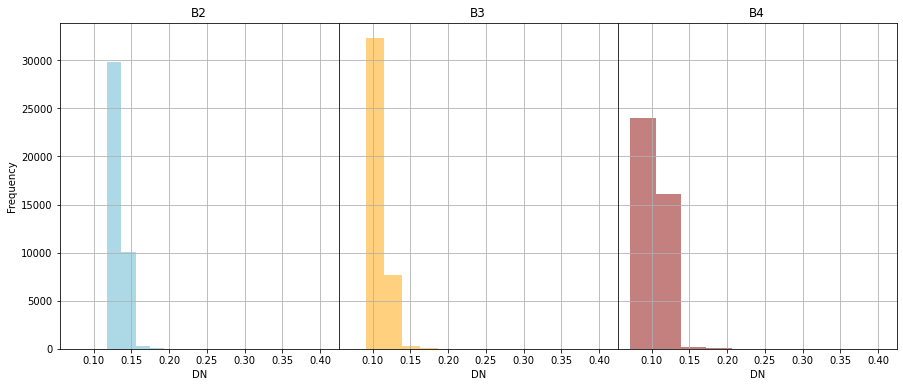

In [ ]:
# Histogram for each RGB Band

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15, 6), sharey=True, sharex = True)

# Plot Bands 2, 3 and 4
show_hist((rgbR, 1), ax=ax1, label=None, facecolor = 'lightblue')
show_hist((rgbR, 2), ax=ax2, label=None, facecolor = 'orange',  alpha = 0.5)
show_hist((rgbR, 3), ax=ax3, label=None, facecolor = 'darkred', alpha = 0.5)
# show_hist((rgbR, 4), ax=ax4, label=None, facecolor = 'darkgreen', alpha = 0.5)

# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0)

# Hide y axis label
ax2.set_ylabel(None)
ax3.set_ylabel(None)
# ax4.set_ylabel(None)

# Hide y axis ticks
ax2.get_yaxis().set_ticks_position('none')
ax3.get_yaxis().set_ticks_position('none')
# ax4.get_yaxis().set_ticks_position('none')

# Add titles
ax1.set_title("B2")
ax2.set_title("B3")
ax3.set_title("B4")
# ax4.set_title("B8")

# Hide legend
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
# ax4.get_legend().remove()

# Save jpeg
plt.savefig("rgbBands_hist.jpeg")

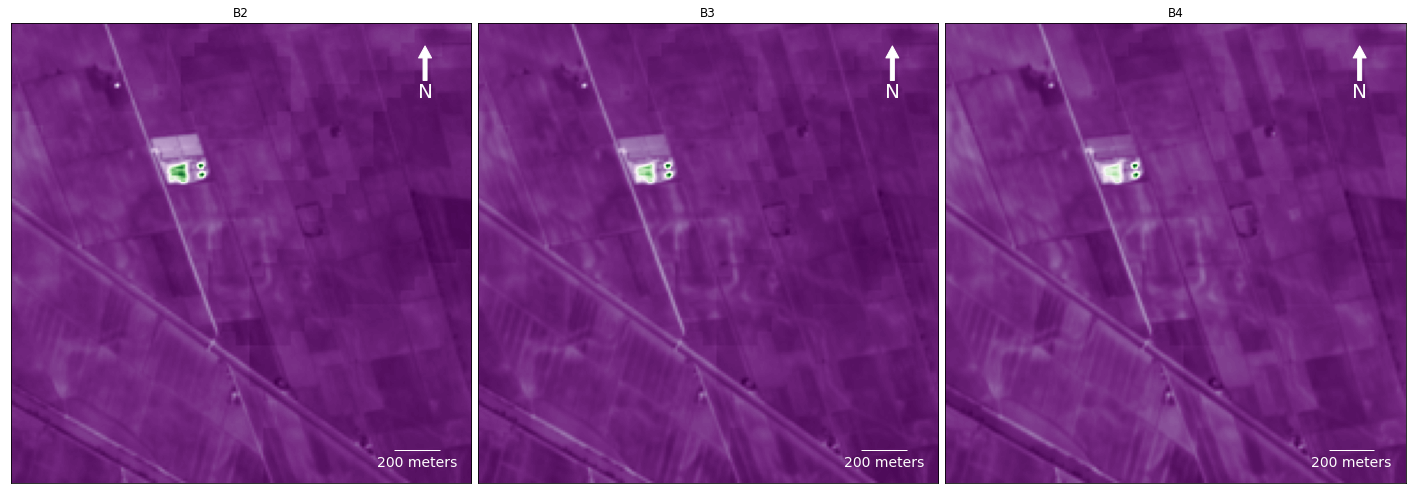

In [ ]:
# Plot all RGB Bands
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(25, 25), sharey=True)

# Plot each PC
show((rgbR, 1), ax=ax1, label=None, cmap = 'PRGn')
show((rgbR, 2), ax=ax2, label=None, cmap = 'PRGn')
show((rgbR, 3), ax=ax3, label=None, cmap = 'PRGn')

# Adjust the space between plots
plt.subplots_adjust(wspace=0.015, hspace=0)

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax2.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
ax1.add_artist(bar1)
ax2.add_artist(bar2)
ax3.add_artist(bar3)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax1.transAxes)
ax2.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax2.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax3.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)

# If you show the axis, rotate the coordinates of the x axis
# ax1.tick_params('x', labelrotation=45)
# ax2.tick_params('x', labelrotation=45)
# ax3.tick_params('x', labelrotation=45)

# Add titles
ax1.set_title("B2")
ax2.set_title("B3")
ax3.set_title("B4")

# Save jpeg image
plt.savefig("rgbBands_plot.jpeg", quality = 99)

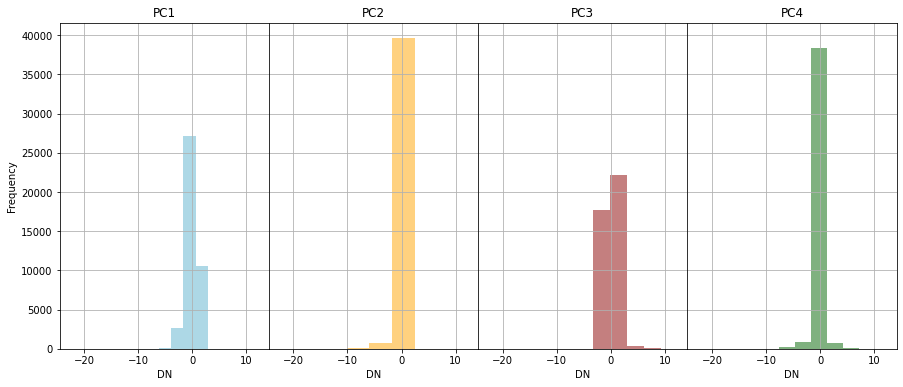

In [ ]:
# Plot each Principal Component Histogram separately

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(15, 6), sharey=True, sharex=True)

# Plot Principal Components 1, 2, 3 and 4
show_hist((pcaR, 1), ax=ax1, label=None, bins = 6, facecolor = 'lightblue')
show_hist((pcaR, 2), ax=ax2, label=None, bins = 6, facecolor = 'orange',  alpha = 0.5)
show_hist((pcaR, 3), ax=ax3, label=None, bins = 6, facecolor = 'darkred', alpha = 0.5)
show_hist((pcaR, 4), ax=ax4, label=None, bins = 6, facecolor = 'darkgreen', alpha = 0.5)

# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0)

# Hide y axis label
ax2.set_ylabel(None)
ax3.set_ylabel(None)
ax4.set_ylabel(None)

# Hide y axis ticks
ax2.get_yaxis().set_ticks_position('none')
ax3.get_yaxis().set_ticks_position('none')
ax4.get_yaxis().set_ticks_position('none')

# Add titles
ax1.set_title("PC1")
ax2.set_title("PC2")
ax3.set_title("PC3")
ax4.set_title("PC4")

# Hide legend
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

# Save jpeg
plt.savefig("pcaBands_hist.jpeg")

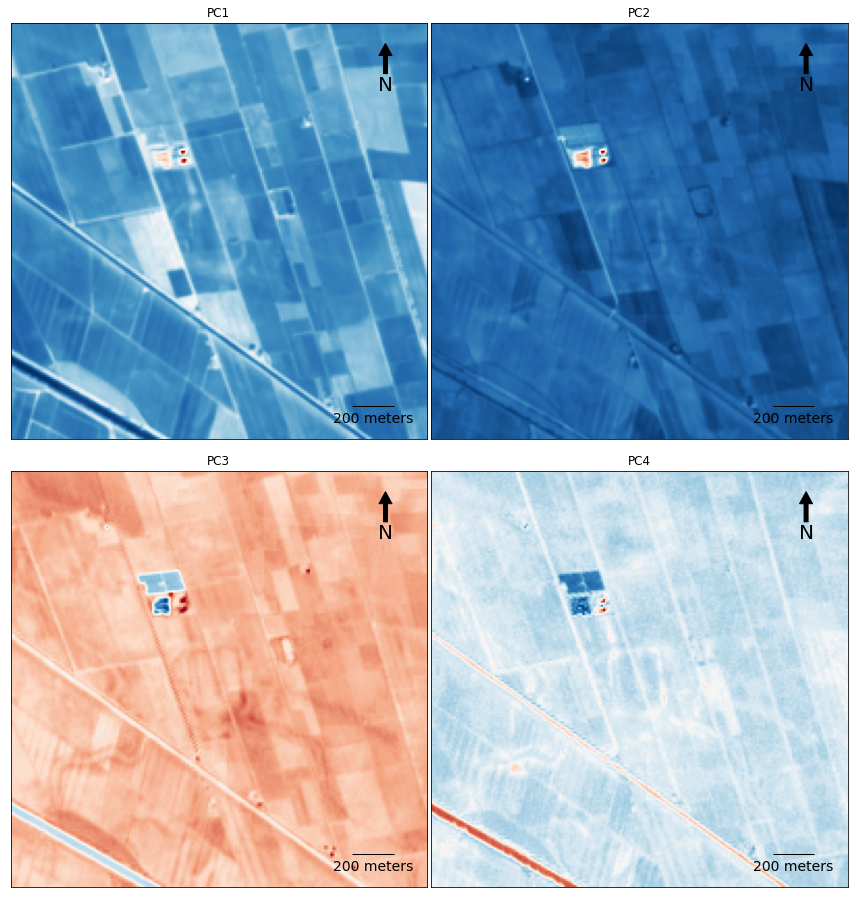

In [ ]:
# Plot all Principal Components
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharey=True, sharex=True)

# Plot each PC
show((pcaR, 1), ax=ax1, label=None, cmap = 'RdBu')
show((pcaR, 2), ax=ax2, label=None, cmap = 'RdBu')
show((pcaR, 3), ax=ax3, label=None, cmap = 'RdBu')
show((pcaR, 4), ax=ax4, label=None, cmap = 'RdBu')

# Adjust the space between plots
plt.subplots_adjust(bottom=0.05, wspace=0.01, hspace=0)

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax2.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar4 = AnchoredSizeBar(ax4.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
ax1.add_artist(bar1)
ax2.add_artist(bar2)
ax3.add_artist(bar3)
ax4.add_artist(bar4)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax1.transAxes)
ax2.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax2.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax3.transAxes)
ax4.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax4.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)


# Add titles
ax1.set_title("PC1")
ax2.set_title("PC2")
ax3.set_title("PC3")
ax4.set_title("PC4")

# Save jpeg image
plt.savefig("pcaBands_plot.jpeg", quality = 99)

In [ ]:
'''
# Plot histogram - Stacked False and True
show_hist(pcaR, bins=10, stacked=False, alpha=0.8, histtype='bar', title="PCA Histogram")
show_hist(pcaR, bins=30, stacked=True, alpha=0.5, histtype='stepfilled', title="PCA Histogram")
'''

'\n# Plot histogram - Stacked False and True\nshow_hist(pcaR, bins=10, stacked=False, alpha=0.8, histtype=\'bar\', title="PCA Histogram")\nshow_hist(pcaR, bins=30, stacked=True, alpha=0.5, histtype=\'stepfilled\', title="PCA Histogram")\n'

In [ ]:
'''
# Plot RGB and PCA
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharey=False)

show((rgbR), ax=ax1, cmap = 'PRGn', transform = tctR.transform)
show((pcaR), ax=ax2, cmap = 'PiYG', transform = pcaR.transform)

ax1.set_title("RGB")
ax2.set_title("PCA")
'''

'\n# Plot RGB and PCA\nfig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharey=False)\n\nshow((rgbR), ax=ax1, cmap = \'PRGn\', transform = tctR.transform)\nshow((pcaR), ax=ax2, cmap = \'PiYG\', transform = pcaR.transform)\n\nax1.set_title("RGB")\nax2.set_title("PCA")\n'

In [ ]:
'''
# Scatter Plot
plt.scatter(pcaR.read(1), pcaR.read(2), alpha=0.5, s=1)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
'''

"\n# Scatter Plot\nplt.scatter(pcaR.read(1), pcaR.read(2), alpha=0.5, s=1)\nplt.xlabel('First Principal Component')\nplt.ylabel('Second Principal Component')\n"